In [1]:
import pandas as pd
import seaborn as sns

pd.set_option("display.precision", 3)
pd.set_option('display.width', 1024)
pd.set_option('display.max_colwidth', None)
from matplotlib import pyplot as plt

### https://blakeaw.github.io/2020-05-25-improve-matplotlib-notebook-inline-res/
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg',"png")
# plt.rcParams['figure.format'] = 'svg'

plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

# plt.rcParams[bbox_inches] = 'tight'
import seaborn as sns
sns.set(rc={"figure.dpi":400, 'savefig.dpi':400})
sns.set_context('notebook')
sns.set_style("ticks")

# plt.rcParams["figure.dpi"] = 600 ## default 72
## https://stackoverflow.com/questions/39870642/matplotlib-how-to-plot-a-high-resolution-graph
## https://www.delftstack.com/howto/matplotlib/how-to-plot-and-save-a-graph-in-high-resolution/

%matplotlib inline 

MIN_PAIR_FREQ = 1
SAVE_TRAIN_DATA = False

LOWERCASE_DATA = False
DROP_DOUBLES = True ## drop white cards with pick 2 options ; and their blacks. (TODO: analyze interesting pairs)
DROP_SKIPPED = True ## ignore rounds where skipped


DRIVE_FILE_PATH = "/content/drive/MyDrive/Research/CAH/cah_lab_data_for_research_XXX_XXX.csv.gz"
## "cah_lab_data_for_research_XXX_XXX.csv"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data

* Note there are some near-duplicate cards (e.g. footballers - could minhash - https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py , LSH/shingles : https://onestopdataanalysis.com/lsh/  (broken library?) , https://github.com/zyocum/dedup/blob/master/dedup.py ,

`Datasketch` https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/ ,
https://stackoverflow.com/questions/25114338/approximate-string-matching-using-lsh , 

SKLearn friendly?: http://ethen8181.github.io/machine-learning/recsys/content_based/lsh_text.html

`dedupe` library - https://github.com/dedupeio/dedupe

* Paraphrase mining using sentence bert - https://www.sbert.net/examples/applications/paraphrase-mining/README.html  (may be too semantic)

* Example: "10 football players with erections *barreling* towards you at full speed" - 10 football players with erections **barrelling** towards you at full speed."

Task modelling:
* Ranking = most accurate
* Regression/classification: can be done just over single cards, or between pairs. 
    * if pairs-wise: can use sentencebert/SNLI models (which assume pairs of sentences) - https://github.com/UKPLab/sentence-transformers
    
    
Examples:

* https://www.sbert.net/examples/training/sts/README.html#training-data
* https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py
* https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli_v2.py


* Keras example (not sentenceBert): https://keras.io/examples/nlp/semantic_similarity_with_bert/


* Interpretability tool : https://github.com/cdpierse/transformers-interpret

In [3]:
df = pd.read_csv(DRIVE_FILE_PATH)
## remove punct/newlines
df["white_card_text"] = df["white_card_text"].replace("\n", " ",regex=True).replace("\t", " ",regex=True) # .replace("\r", "")
df["black_card_text"] = df["black_card_text"].replace("\n", " ",regex=True).replace("\t", " ",regex=True) # .replace("\r", "")

# df = df.replace("\[rnt]", "",regex=True)#.replace("\n", " ").replace("\t", " ")
# df["black_card_text"] = df["black_card_text"].replace("\r", "").replace("\n", " ").replace("\t", " ")


print(df[['black_card_text', 'black_card_pick_num', 'white_card_text',"fake_round_id"]].nunique())
print(df.describe())
df

black_card_text           650
black_card_pick_num         2
white_card_text          2128
fake_round_id          298955
dtype: int64
       fake_round_id  round_completion_seconds  black_card_pick_num  winning_index
count      2.990e+06                 2.990e+06            2.990e+06     318508.000
mean       1.495e+05                 9.344e+01            1.133e+00          0.116
std        8.630e+04                 3.353e+03            3.399e-01          0.320
min        1.000e+00                 2.000e+00            1.000e+00          0.000
25%        7.474e+04                 1.000e+01            1.000e+00          0.000
50%        1.495e+05                 1.700e+01            1.000e+00          0.000
75%        2.242e+05                 2.800e+01            1.000e+00          0.000
max        2.990e+05                 7.021e+05            2.000e+00          1.000


,fake_round_id,round_completion_seconds,round_skipped,black_card_text,black_card_pick_num,white_card_text,won,winning_index
0,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Going inside at some point because of the mosquitoes.,False,NaN
1,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Being fat from noodles.,False,NaN
2,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Letting this loser eat me out.,False,NaN
3,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,That chicken from Popeyes.®,False,NaN
4,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,A sorry excuse for a father.,False,NaN
...,...,...,...,...,...,...,...,...
2989545,298955,7613,False,Oh my god! _____ killed Kenny!,1,Breastfeeding a ten-year-old.,False,NaN
2989546,298955,7613,False,Oh my god! _____ killed Kenny!,1,Happy daddies with happy sandals.,False,NaN
2989547,298955,7613,False,Oh my god! _____ killed Kenny!,1,Jerking off to a 10-second RealMedia clip.,False,NaN
2989548,298955,7613,False,Oh my god! _____ killed Kenny!,1,Getting naked and watching Nickelodeon.,False,NaN


##### analyze rounds skipped
* at level of round -  5% of rounds skipped due to all combinations being considered "unfunny"

In [4]:
df.drop_duplicates("fake_round_id")["round_skipped"].mean()

0.058145874797210284

In [5]:
# df.dropna(subset=["winning_index"])["black_card_text"].drop_duplicates().values

df["double_card"] = df["black_card_text"].str.count("_____")>1
print(df["double_card"].describe())
df.loc[df["double_card"]].drop_duplicates("black_card_text")


count     2989550
unique          2
top         False
freq      2578330
Name: double_card, dtype: object


,fake_round_id,round_completion_seconds,round_skipped,black_card_text,black_card_pick_num,white_card_text,won,winning_index,double_card
110,12,42,False,"That's right, I killed _____. How, you ask? _____.",2,China.,True,0.0,True
160,17,3,False,"Listen, son. If you want to get involved with _____, I won't stop you. Just steer clear of _____.",2,Watching the life drain from the eyes of my son's killer.,False,NaN,True
170,18,79,False,"When I was tripping on acid, _____ turned into _____.",2,Flirting with the ladies at the bank.,False,NaN,True
270,28,26,False,"If God didn't want us to enjoy _____, he wouldn't have given us _____.",2,Throw up.,False,NaN,True
310,32,8,False,Step 1: _____. Step 2: _____. Step 3: Profit.,2,Quacking like a duck in lieu of a cogent argument.,False,NaN,True
...,...,...,...,...,...,...,...,...,...
2903880,290389,15,False,"I'm _____, you're _____, let's party! (PICK 2)",2,Ejaculating at the apex of a cartwheel.,False,NaN,True
2910940,291095,25,False,"You: _____. Me, an intellectual: _____. (PICK 2)",2,"The primal, ball-slapping sex your parents are having right now.",False,NaN,True
2930320,293033,18,False,Dudes. I just found out that _____ is _____.,2,A real cum-dumpster of a saxophonist.,True,1.0,True
2934140,293415,8,False,"Critics are raving about HBO's new fantasy series, ""_____ of _____."" (PICK 2)",2,Running out of semen.,False,NaN,True


In [6]:
if LOWERCASE_DATA:
    df["white_card_text"] = df["white_card_text"].str.lower()
    df["black_card_text"] = df["black_card_text"].str.lower()

In [7]:
df["white_card_text"].drop_duplicates().str.split().str.len().describe()

count    2128.000
mean        4.962
std         3.216
min         1.000
25%         2.000
50%         4.000
75%         7.000
max        23.000
Name: white_card_text, dtype: float64

In [8]:
df["black_card_text"].drop_duplicates().str.split().str.len().describe()

count    650.000
mean      11.295
std        5.232
min        2.000
25%        7.000
50%       11.000
75%       14.000
max       41.000
Name: black_card_text, dtype: float64

In [9]:
df.groupby(by="white_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"))

,picks,pick_opportunities,pick_ratio
white_card_text,,,
...it is unclear.,97,1576,0.062
10 Incredible Facts About the Anus.,156,1512,0.103
10 football players with erections barreling towards you at full speed.,4,34,0.118
10 football players with erections barrelling towards you at full speed.,207,1465,0.141
"10,000 Syrian refugees.",204,1531,0.133
...,...,...,...
Your mouth.,174,1600,0.109
Your weird brother.,191,1552,0.123
Yummy yummy yummy yummy rat pussy.,261,1548,0.169


In [10]:
print("white cards against humanity - aggregated funniest")
df_white = df.groupby(by="white_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean")).sort_values("pick_ratio",ascending=False)

print(df_white.describe())
df_white

white cards against humanity - aggregated funniest
          picks  pick_opportunities  pick_ratio  round_skip_ratio
count  2128.000            2128.000    2128.000          2128.000
mean    149.675            1404.864       0.106             0.059
std      87.077             408.717       0.053             0.013
min       0.000              19.000       0.000             0.000
25%      91.750            1490.000       0.067             0.054
50%     139.000            1522.000       0.096             0.058
75%     203.000            1552.000       0.138             0.063
max     459.000            3006.000       0.357             0.192


,picks,pick_opportunities,pick_ratio,round_skip_ratio
white_card_text,,,,
Syphilis.,10,28,0.357,0.036
Anal.,459,1572,0.292,0.034
"Sluts, whores, and bitches.",456,1598,0.285,0.054
Tentacle porn.,434,1525,0.285,0.066
Incest.,435,1530,0.284,0.047
...,...,...,...,...
Bupkis.,0,32,0.000,0.125
Also being named Harvey Weinstein.,0,28,0.000,0.071
The mere concept of Applebee's.®,0,26,0.000,0.038


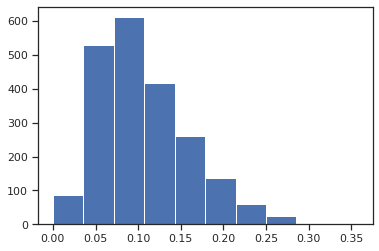

In [11]:
df_white["pick_ratio"].hist(grid=False)#,legend=True);

#### Fig 1a- Card counts	

In [12]:
# sns.histplot([df["white_card_text"].value_counts(),df["black_card_text"].value_counts()])

In [13]:
fig = sns.histplot([df["white_card_text"].value_counts(),df["black_card_text"].value_counts()])
fig.set_yscale('log')
fig.set_xscale('log')
legend = fig.get_legend()
handles = legend.legendHandles
legend.remove()
# fig.legend(handles, ['White Cards', 'Black Cards'])#, title='Card counts')
fig.legend(handles, ['Punchline Cards', 'Prompt Cards'])
# plt.savefig('Fig 1a- Card counts.svg')
plt.savefig('Fig 1a- Card counts.png',bbox_inches='tight')

Add d Pseudo joint text col / "joke", mainly for eda purposes

In [14]:
df["joke"] = df["black_card_text"] + df["white_card_text"]

In [15]:
print("Potential unique jokes:",df["black_card_text"].nunique() * df["white_card_text"].nunique())
print("# Jokes observed:",df["joke"].nunique())
print("Fraction% of jokes covered:",100*df["joke"].nunique()/(df["black_card_text"].nunique() * df["white_card_text"].nunique()))

Potential unique jokes: 1383200
# Jokes observed: 908362
Fraction% of jokes covered: 65.67105263157895


### Fig 1b- Punchline win rate
* Pick ratio (win rate frequency) of punchlines, across all games. A random, uniform distribution would be 0.10 for all.

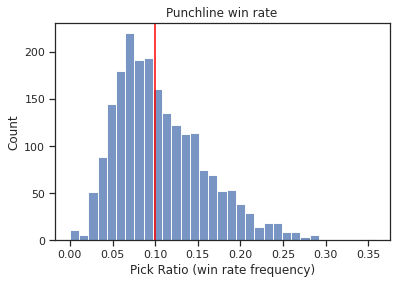

In [16]:
## https://cmdlinetips.com/2019/02/how-to-make-histogram-in-python-with-pandas-and-seaborn/
fig = sns.histplot(df_white["pick_ratio"])#,x="Pick Ratio (win rate frequency)")
fig.set(xlabel="Pick Ratio (win rate frequency)",  title='Punchline win rate') # ylabel='common ylabel',
plt.axvline(0.1,color="red")

plt.savefig('Fig 1b- Punchline win rate.png',bbox_inches='tight')


#### Fig 1c- Joke counts	
* "Joke" Counts/histogram (white + black combinations):
1d. Counts for winning combinations only
* Jokes’ counts, occurring across all games. 36% appear less than 3 times.

https://seaborn.pydata.org/generated/seaborn.countplot.html

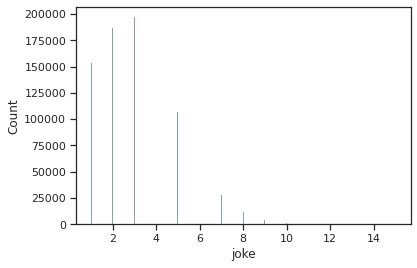

In [17]:
joke_counts = df["joke"].value_counts()

# sns.countplot(df[["white_card_text","black_card_text"]].value_counts(),x="Joke counts")
# sns.countplot(df["joke"].value_counts(),x="Joke counts")
fig = sns.histplot(joke_counts)#,bins=7)
# df["joke"].value_counts().hist()


plt.savefig('Fig 1c- Joke counts.png',bbox_inches='tight')

In [18]:
# joke_counts.plot(kind= "kde")#"hist")

##### Joke counts by wins and sparsity - cont

In [19]:
print((df["joke"].value_counts()==1).mean())
print((df["joke"].value_counts()==2).mean())

0.16927172206675312
0.20506912442396313


In [20]:
## sparsity? : 
print("# jokes played and won:",df.loc[df["won"]]["joke"].nunique())
print("Therre are ~ 650 * 2128 (1.38 Million) potential unique jokes")

# jokes played and won: 248896
Therre are ~ 650 * 2128 (1.38 Million) potential unique jokes


In [21]:
# g = sns.catplot(x="joke", #hue="who",
#                 col="won",
#                 data=df, kind="count")
# g

print((df.loc[df["won"]][["joke"]].value_counts()==1).mean())
print((df.loc[df["won"]][["joke"]].value_counts()==2).mean())

0.7786223965029571
0.1748441115968115


### Fig 1d: Picked Jokes counts	
* Frequency (percent) histogram of jokes being picked as winners


count    248896.00
mean          1.28
std           0.59
min           1.00
25%           1.00
50%           1.00
75%           1.00
max           8.00
dtype: float64

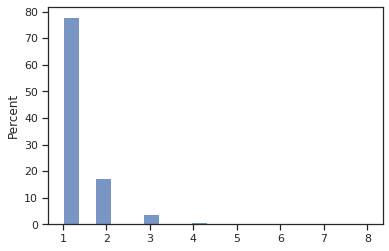

In [22]:
display(df.loc[df["won"]][["joke"]].value_counts().describe().round(2))
sns.histplot(df.loc[df["won"]][["joke"]].value_counts(),stat="percent")#,x="Winning joke counts")

In [23]:
df[["white_card_text","black_card_text"]].value_counts()

white_card_text         black_card_text                                                                             
Having a heart attack.  Bitch, you're nasty. You're disgusting. You're _____. Go home, bitch.                           15
Déjà vu.                Why am I laughing and crying and taking off my clothes?                                         15
                        This year's hottest album is "_____" by _____.                                                  14
A Bop It.™              I tell you, it was a non-stop fuckfest. When it was over, my asshole looked like _____.         14
Deez nuts.              Your persistence is admirable, my dear Prince. But you cannot win my heart with _____ alone.    14
                                                                                                                        ..
Gay aliens.             You want _____? You can't handle _____! (SAME CARD AGAIN)                                        1
                      

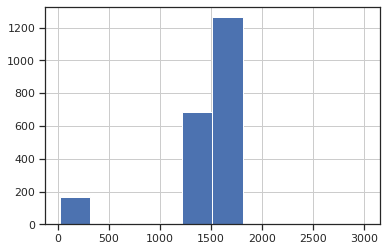

In [24]:
df["white_card_text"].value_counts().hist()

In [25]:
df_white.sort_values("pick_ratio",ascending=False).head(20).reset_index()["white_card_text"].values

array(['Syphilis.', 'Anal.', 'Sluts, whores, and bitches.',
       'Tentacle porn.', 'Incest.', 'A big black dick.', 'Cock.',
       'The death penalty.', 'Gay thoughts.',
       'Three dicks at the same time.', 'The Asshole Destroyer 3000.',
       'Dem titties.', 'Masturbating.', 'Horny Christian teens.',
       'Double penetration.', 'Masturbating to ISIS beheading videos.',
       'Crazy anal orgasms.', 'COVID-19.', 'Elf cum.', 'Joe Biden.'],
      dtype=object)

In [26]:
df_white.sort_values("pick_ratio",ascending=True).head(10)#.reset_index()["white_card_text"].values

,picks,pick_opportunities,pick_ratio,round_skip_ratio
white_card_text,,,,
Saudi oil money.,0,24,0.0,0.083
The whole enchilada.,0,24,0.0,0.000
Holding a pepper grinder for some reason.,0,21,0.0,0.048
Lips that could suck the chrome off a doorknob.,0,21,0.0,0.095
"JFK’s smiling, exploding head.",0,24,0.0,0.083
Swedes.,0,30,0.0,0.067
Acknowledging that we stand on the unceded lands of Indigenous peoples.,0,33,0.0,0.152
The mere concept of Applebee's.®,0,26,0.0,0.038
"The bond of brotherhood forged in battle, unbreakable and eternal.",0,30,0.0,0.067


11 0 picks
127 1-5 picks
          picks  pick_opportunities  pick_ratio  round_skip_ratio
count  2128.000            2128.000    2128.000          2128.000
mean    149.675            1404.864       0.106             0.059
std      87.077             408.717       0.053             0.013
min       0.000              19.000       0.000             0.000
25%      91.750            1490.000       0.067             0.054
50%     139.000            1522.000       0.096             0.058
75%     203.000            1552.000       0.138             0.063
max     459.000            3006.000       0.357             0.192


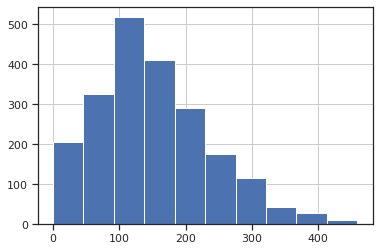

In [27]:
print(df_white.loc[df_white["picks"]==0].shape[0], "0 picks")
print(df_white.loc[df_white["picks"].between(1,5)].shape[0], "1-5 picks")

print(df_white.describe().round(3))

df_white["picks"].hist();

In [28]:
df.groupby(by="black_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean")).sort_values(["pick_ratio"],ascending=False)

,picks,pick_opportunities,pick_ratio,round_skip_ratio
black_card_text,,,,
"You: _____. Me, an intellectual: _____. (PICK 2)",10,50,0.200,0.000
Problem: _____. Solution: _____. (PICK 2),14,70,0.200,0.000
"In JorXXX Peele's new thriller, a young family discovers that _____ had really been _____ all along.",206,1070,0.193,0.037
_____ is a slippery slope that leads to _____.,1300,6790,0.191,0.043
_____ would be woefully incomplete without _____.,1334,6970,0.191,0.043
...,...,...,...,...
"Instead of playing a card this round, everyone must stare at the Card Czar while making a sound you'd make after tasting something delicious.",462,6550,0.071,0.295
Up on the shore they work all day Out in the sun they slave away While we devotin' Full time to _____ Under the sea!,2,30,0.067,0.333
"I hate to be that guy, but I just don't see the point of _____.",2,30,0.067,0.333


## Black ("Question") Cards

In [29]:
print("BLACK cards against humanity - aggregated funniest")
## pick doesn't necessarily make sense here
df_black = df.groupby(by="black_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean"))
df_black.sort_values(["pick_ratio","round_skip_ratio"],ascending=False,inplace=True)

df_black

BLACK cards against humanity - aggregated funniest


,picks,pick_opportunities,pick_ratio,round_skip_ratio
black_card_text,,,,
Problem: _____. Solution: _____. (PICK 2),14,70,0.200,0.000
"You: _____. Me, an intellectual: _____. (PICK 2)",10,50,0.200,0.000
"In JorXXX Peele's new thriller, a young family discovers that _____ had really been _____ all along.",206,1070,0.193,0.037
_____ is a slippery slope that leads to _____.,1300,6790,0.191,0.043
_____ would be woefully incomplete without _____.,1334,6970,0.191,0.043
...,...,...,...,...
"Instead of playing a card this round, everyone must stare at the Card Czar while making a sound you'd make after tasting something delicious.",462,6550,0.071,0.295
"I am so, so sorry everyone. I take full responsibility for _____.",2,30,0.067,0.333
"I hate to be that guy, but I just don't see the point of _____.",2,30,0.067,0.333


In [30]:
df_black.sort_values(["picks","pick_opportunities"],ascending=False)

,picks,pick_opportunities,pick_ratio,round_skip_ratio
black_card_text,,,,
"When you get right down to it, _____ is just _____.",1392,7430,0.187,0.063
My life is ruled by a vicious cycle of _____ and _____.,1386,7350,0.189,0.057
"This year's hottest album is ""_____"" by _____.",1356,7300,0.186,0.071
My mom freaked out when she looked at my browser history and found _____.com/_____.,1356,7280,0.186,0.069
"You know, once you get past _____, _____ ain't so bad.",1354,7200,0.188,0.060
...,...,...,...,...
"I am so, so sorry everyone. I take full responsibility for _____.",2,30,0.067,0.333
"I hate to be that guy, but I just don't see the point of _____.",2,30,0.067,0.333
Up on the shore they work all day Out in the sun they slave away While we devotin' Full time to _____ Under the sea!,2,30,0.067,0.333


In [31]:
df_black.describe().round(2)

,picks,pick_opportunities,pick_ratio,round_skip_ratio
count,650.00,650.00,650.00,650.00
mean,490.01,4599.31,0.10,0.06
std,356.67,2850.48,0.03,0.05
min,1.00,10.00,0.06,0.00
25%,86.25,932.50,0.09,0.04
50%,592.00,6275.00,0.10,0.05
75%,624.00,6550.00,0.10,0.07
max,1392.00,7430.00,0.20,0.40


#### Filter data

* drop pick 2  cards
* Drop rounds where no card picked (ALT: could be alternate target)

In [32]:
if DROP_DOUBLES:
    df = df.loc[~df["double_card"]]
    
if DROP_SKIPPED:
    df = df.loc[~df["round_skipped"]]
    
print(df.shape[0])
print(df.nunique())

2434500
fake_round_id               243450
round_completion_seconds      1657
round_skipped                    1
black_card_text                581
black_card_pick_num              1
white_card_text               2128
won                              2
winning_index                    1
double_card                      1
joke                        782827
dtype: int64


### Analyze pairs
* Note cases with few occurrences imbalance the data
* This is pairs that actually were shown to users (i.e #picks >= 1) 

In [33]:
print("Winning pair combinations - aggregated funniest")
df_pairs = df.groupby(by=["white_card_text","black_card_text"]).agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean")).sort_values("pick_ratio",ascending=False)

df_pairs

Winning pair combinations - aggregated funniest


picks  pick_opportunities  pick_ratio  round_skip_ratio
white_card_text                                         black_card_text                                                                                                                                                                      
Nonsexual activities, such as roller skating.           And now, from WHYY in Philadelphia, it's _____ with Terry Gross.                                                                  1                   1         1.0               0.0
Murder.                                                 As Teddy Roosevelt said, the four manly virtues are honor, temperance, industry, and _____.                                       1                   1         1.0               0.0
A gay Republican somehow.                               She's a lady in the streets, _____ in the sheets.                                                                                 1                   1         1.0               0.0
A terrified fat child who won't come out of the bushes. My grandfather worked his way up from nothing. When he came to this country, all he had was the shoes on his feet and _____.      1                   1         1.0               0.0
Genghis Khan's DNA.                                     "This is madness!" "No. THIS IS _____!"                                                                                           1                   1         1.0               0.0
...                                                                                                                                                                                     ...                 ...         ...               ...
Frantically writing equations on a chalkboard.          _____. Betcha can't have just one!                                                                                                0                   5         0.0               0.0
                                                        _____. High five, bro.                                                                                                            0                   4         0.0               0.0
                                                        _____. It's a trap!                                                                                                               0                   6         0.0               0.0
                                                        _____. That was so metal.                                                                                                         0                   3         0.0               0.0
marvel                                                  ✮✩✩✩✩ Do NOT go here! Found _____ in my fettuccine alfredo!                                                                       0                   1         0.0               0.0

[782827 rows x 4 columns]

In [34]:
df_pairs.describe()

,picks,pick_opportunities,pick_ratio,round_skip_ratio
count,782827.000,782827.000,782827.000,782827.0
mean,0.311,3.110,0.100,0.0
std,0.600,1.691,0.208,0.0
min,0.000,1.000,0.000,0.0
25%,0.000,2.000,0.000,0.0
50%,0.000,3.000,0.000,0.0
75%,1.000,4.000,0.111,0.0
max,8.000,15.000,1.000,0.0


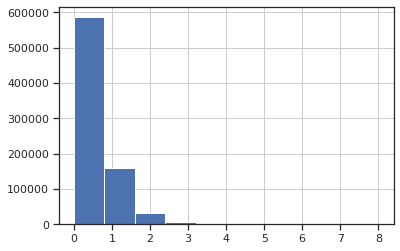

In [35]:
df_pairs["picks"].hist();

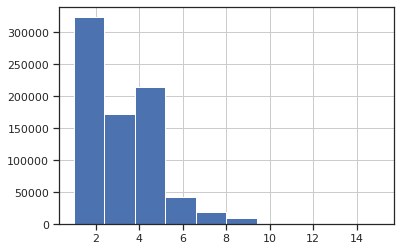

In [36]:
df_pairs["pick_opportunities"].hist();

In [37]:
print(f"Distrib for pairs that had AT LEAST MIN_PAIR_FREQ ({MIN_PAIR_FREQ})")
print(df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ].describe())
df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ]

Distrib for pairs that had AT LEAST MIN_PAIR_FREQ (1)
            picks  pick_opportunities  pick_ratio  round_skip_ratio
count  782827.000          782827.000  782827.000          782827.0
mean        0.311               3.110       0.100               0.0
std         0.600               1.691       0.208               0.0
min         0.000               1.000       0.000               0.0
25%         0.000               2.000       0.000               0.0
50%         0.000               3.000       0.000               0.0
75%         1.000               4.000       0.111               0.0
max         8.000              15.000       1.000               0.0


picks  pick_opportunities  pick_ratio  round_skip_ratio
white_card_text                                         black_card_text                                                                                                                                                                      
Nonsexual activities, such as roller skating.           And now, from WHYY in Philadelphia, it's _____ with Terry Gross.                                                                  1                   1         1.0               0.0
Murder.                                                 As Teddy Roosevelt said, the four manly virtues are honor, temperance, industry, and _____.                                       1                   1         1.0               0.0
A gay Republican somehow.                               She's a lady in the streets, _____ in the sheets.                                                                                 1                   1         1.0               0.0
A terrified fat child who won't come out of the bushes. My grandfather worked his way up from nothing. When he came to this country, all he had was the shoes on his feet and _____.      1                   1         1.0               0.0
Genghis Khan's DNA.                                     "This is madness!" "No. THIS IS _____!"                                                                                           1                   1         1.0               0.0
...                                                                                                                                                                                     ...                 ...         ...               ...
Frantically writing equations on a chalkboard.          _____. Betcha can't have just one!                                                                                                0                   5         0.0               0.0
                                                        _____. High five, bro.                                                                                                            0                   4         0.0               0.0
                                                        _____. It's a trap!                                                                                                               0                   6         0.0               0.0
                                                        _____. That was so metal.                                                                                                         0                   3         0.0               0.0
marvel                                                  ✮✩✩✩✩ Do NOT go here! Found _____ in my fettuccine alfredo!                                                                       0                   1         0.0               0.0

[782827 rows x 4 columns]

In [38]:
print("popular pairs / multiple times picked")
df_pop = df_pairs.loc[(df_pairs["pick_opportunities"]>=2) & (df_pairs["picks"]>1)].sort_values("picks",ascending=False)
print(df_pop.describe().round(2))
print(df_pop.shape[0])
print("nunique",df_pop.reset_index()[["black_card_text","white_card_text"]].nunique())
df_pop.reset_index()[["black_card_text","white_card_text","picks"]].head(12)

popular pairs / multiple times picked
          picks  pick_opportunities  pick_ratio  round_skip_ratio
count  38412.00            38412.00    38412.00           38412.0
mean       2.22                4.74        0.52               0.0
std        0.51                1.67        0.20               0.0
min        2.00                2.00        0.13               0.0
25%        2.00                4.00        0.40               0.0
50%        2.00                5.00        0.50               0.0
75%        2.00                6.00        0.67               0.0
max        8.00               15.00        1.00               0.0
38412
nunique black_card_text     437
white_card_text    1951
dtype: int64


,black_card_text,white_card_text,picks
0,"Hey, honey. For the bedroom, were you thinking ""Robin's Egg Blue"" or ""_____ Pink?""",My first period.,8
1,"Run, run, as fast as you can! You can't catch me, I'm _____!",COVID-19.,8
2,"Hey, honey. For the bedroom, were you thinking ""Robin's Egg Blue"" or ""_____ Pink?""",Chunks of dead hitchhiker.,7
3,Click Here for _____!!!,"Bill Clinton, naked on a bearskin rug with a saxophone.",7
4,"Introducing X-treme Baseball! It's like baseball, but with _____!",Masturbating.,6
5,"Nothing says ""I love you"" like _____.",Necrophilia.,6
6,The Department of Psychology is looking for paid research volunteers. Are you 18-25 and suffering from _____?,Some really fucked-up shit.,6
7,"Awww, sick! I just saw this skater do a 720 kickflip into _____!",My math teacher's bulge.,6
8,"Hi, this is Jim from accounting. We noticed a $1,200 charge labeled ""_____."" Can you explain?",A sad handjob.,6
9,What sounds great after four margaritas?,Punching a congressman in the face.,6


In [39]:
# df_pop.loc[df_pop["picks"]>2].reset_index().sort_values(["white_card_text","picks"],ascending=False)[["white_card_text","black_card_text"]].head(15).values
df_pop.loc[df_pop["picks"]>2].reset_index().sort_values(["white_card_text","picks"],ascending=False)["black_card_text"].head(15).values

array(['FW: re: FBI WARNING!!! VIOLENT GANGS USING _____ TO RECRUIT CHILDREN!',
       'Computer! Display _____ on screen. Enhance.',
       "Seriously guys, there's nothing funny about _____.",
       "Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",
       'The secret to a lasting marriage is communication, communication, and _____.',
       'The blind date was going horribly until we discovered our shared interest in _____.',
       "After four platinum albums and three Grammys, it's time to get back to my roots, to what inspired me to make music in the first place: _____.",
       'Why my mustache smell so bad?',
       'Having tired of poetry and music, the immortal elves now fill their days with _____.',
       'What will end racism once and for all?',
       '_____: kid-tested, mother-approved.',
       'IF you like _____, YOU MIGHT BE A REDNECK.',
       'What totally destroyed my asshole?',
       'Why my mustache smell so bad?',
 

In [40]:
df_pairs.loc[df_pairs["pick_opportunities"]>=4].head()

,,picks,pick_opportunities,pick_ratio,round_skip_ratio
white_card_text,black_card_text,,,,
A gay Republican somehow.,"Coming to Red Lobster® this month, _____.",4,4,1.0,0.0
The Great Depression.,What are all those whales singing about?,5,5,1.0,0.0
Viagra.®,"I've got rhythm, I've got music, I've got _____. Who could ask for anything more?",5,5,1.0,0.0
Forty-two years of repressed homosexuality.,What is George W. Bush thinking about right now?,4,4,1.0,0.0
The Devil himself.,Jesus is _____.,5,5,1.0,0.0


In [41]:
df_pairs[["pick_opportunities","picks","pick_ratio"]].corr() # ,"picks_sum"

,pick_opportunities,picks,pick_ratio
pick_opportunities,1.000,0.285,0.003
picks,0.285,1.000,0.809
pick_ratio,0.003,0.809,1.000


In [42]:
print(" 2<=",df_pairs.loc[df_pairs["pick_opportunities"]<=2].shape[0])
print(" >= 3",df_pairs.loc[df_pairs["pick_opportunities"]>=3].shape[0])
print(" >= 5",df_pairs.loc[df_pairs["pick_opportunities"]>=5].shape[0])
print(" >= 7",df_pairs.loc[df_pairs["pick_opportunities"]>=7].shape[0])
100*df_pairs["pick_opportunities"].value_counts(normalize=True).round(4).sort_index()

 2<= 323559
 >= 3 459268
 >= 5 154501
 >= 7 29652


1     19.10
2     22.23
3     22.03
4     16.90
5     10.51
6      5.43
7      2.41
8      0.92
9      0.32
10     0.10
11     0.03
12     0.01
13     0.00
14     0.00
15     0.00
Name: pick_opportunities, dtype: float64

In [43]:
print(df_pairs["picks"].value_counts().sort_index())
100*df_pairs["picks"].value_counts(normalize=True).sort_index()

0    586246
1    158169
2     31409
3      5779
4      1024
5       176
6        20
7         2
8         2
Name: picks, dtype: int64


0    7.489e+01
1    2.020e+01
2    4.012e+00
3    7.382e-01
4    1.308e-01
5    2.248e-02
6    2.555e-03
7    2.555e-04
8    2.555e-04
Name: picks, dtype: float64

# Initial classification target:  Was a card combination ever picked? 
* Ideally we'd use a higher threshhold, e.g. at least 3-5 instances, but that leaves us with relatively little data. 
* binary target: was it ever picked, for a given combo. (i.e clip at 1, 0/1)

In [44]:
df_pairs["pick_opportunities"].describe()

count    782827.000
mean          3.110
std           1.691
min           1.000
25%           2.000
50%           3.000
75%           4.000
max          15.000
Name: pick_opportunities, dtype: float64

* We can set the target to be picked at leat once, or picked more than a random uniform average (~10.6%)
    * We can use the background uniform distribution, instead of the distrib for "popularly picked". 

In [45]:
df_pairs["pick_ratio"] = df_pairs["picks"].div(df_pairs["pick_opportunities"])
# print("global pick_ratio\n",df_pairs["pick_ratio"].describe())
print(df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ]["pick_ratio"].describe())

MEAN_PICK_RATIO = df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ]["pick_ratio"].mean() + 0.005 # .median() #

count    782827.000
mean          0.100
std           0.208
min           0.000
25%           0.000
50%           0.000
75%           0.111
max           1.000
Name: pick_ratio, dtype: float64


In [46]:
print(df_pairs.shape[0],f"# rows before filter of MIN_PAIR_FREQ ({MIN_PAIR_FREQ})")
df_data = df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ][["picks","pick_opportunities"]].copy()
df_data["pick_ratio"] = df_data["picks"].div(df_data["pick_opportunities"]) ## target % , instead of boolean
df_data["picks_sum"] = df_data["picks"] # copy of raw count of times picked as funny
## We can set the target to be picked at leat once, or picked more than a random uniform average (~10.6%)
df_data["picks"] = df_data["picks"].clip(upper=1) # Bool target 
print(df_data["picks"].mean(), "boolean target mean")

# ## OPTIONAL: change to "picked more than most" target
# df_data["picks"] = (df_data["pick_ratio"] > MEAN_PICK_RATIO).astype(int)

print(df_data.shape[0],"# rows after filter")
print("pick_ratio\n",df_data["pick_ratio"].describe())
print(df_data["picks"].mean(), "target mean")

782827 # rows before filter of MIN_PAIR_FREQ (1)
0.2511167857010553 boolean target mean
782827 # rows after filter
pick_ratio
 count    782827.000
mean          0.100
std           0.208
min           0.000
25%           0.000
50%           0.000
75%           0.111
max           1.000
Name: pick_ratio, dtype: float64
0.2511167857010553 target mean


In [47]:
## add total count of black, white cards
df_data = df_data.join(df_black[["pick_opportunities","round_skip_ratio"]].rename(columns={"pick_opportunities":"black_counts",
                                                                                 "round_skip_ratio":"black_round_skip_ratio"}),  on="black_card_text")

df_data = df_data.join(df_white[["pick_opportunities"]].rename({"pick_opportunities":"white_counts" },axis=1),on="white_card_text")

df_data.reset_index(inplace=True)
print(df_data.shape)
df_data.sort_values(["pick_ratio"],ascending=False)

(782827, 9)


,white_card_text,black_card_text,picks,pick_opportunities,pick_ratio,picks_sum,black_counts,black_round_skip_ratio,white_counts
0,"Nonsexual activities, such as roller skating.","And now, from WHYY in Philadelphia, it's _____ with Terry Gross.",1,1,1.0,1,70,0.000,1505
12031,The government.,What makes me cry every time?,1,1,1.0,1,1240,0.024,1575
12037,Sucking the caviar straight out of a fish's pussy.,"I work my ass off all day for this family, and this is what I come home to? _____!?",1,1,1.0,1,6320,0.047,1472
12036,A positive male role model.,"I just took a DNA test, turns out I'm 100% _____.",1,1,1.0,1,1260,0.087,1533
12035,Sucking the caviar straight out of a fish's pussy.,I have solved politics. My solution is _____.,1,1,1.0,1,6390,0.050,1472
...,...,...,...,...,...,...,...,...,...
391990,Sewing two hamsters together to make a Double Hamster Supreme.,"This season at Steppenwolf, Samuel Beckett's classic existential play: Waiting for _____.",0,2,0.0,0,6100,0.090,1489
391989,Sewing two hamsters together to make a Double Hamster Supreme.,"This season at Manhattan Theatre Club: ""Who's afraid of _____?""",0,2,0.0,0,6640,0.047,1489
391988,Sewing two hamsters together to make a Double Hamster Supreme.,This is your captain speaking. Fasten your seatbelts and prepare for _____.,0,3,0.0,0,6550,0.053,1489
391987,Sewing two hamsters together to make a Double Hamster Supreme.,"The Japanese have developed a smaller, more efficient version of _____.",0,1,0.0,0,6790,0.059,1489


In [53]:
df_data.describe().round(2)

,picks,pick_opportunities,pick_ratio,picks_sum,black_counts,black_round_skip_ratio,white_counts
count,782827.00,782827.00,782827.00,782827.00,782827.00,782827.00,782827.00
mean,0.25,3.11,0.10,0.31,6095.87,0.06,1515.04
std,0.43,1.69,0.21,0.60,1322.21,0.02,135.89
min,0.00,1.00,0.00,0.00,10.00,0.00,19.00
25%,0.00,2.00,0.00,0.00,6180.00,0.04,1500.00
50%,0.00,3.00,0.00,0.00,6390.00,0.05,1527.00
75%,1.00,4.00,0.11,1.00,6580.00,0.06,1554.00
max,1.00,15.00,1.00,8.00,7410.00,0.40,3006.00


## Save data with just 3 cols

In [51]:
df.describe()

,picks
count,782827.000
mean,0.251
std,0.434
min,0.000
25%,0.000
50%,0.000
75%,1.000
max,1.000


In [48]:
if SAVE_TRAIN_DATA:
    df_data[["black_card_text","white_card_text","picks","pick_opportunities","picks_sum"]].sample(frac=1).to_csv(f"cah_min{MIN_PAIR_FREQ}_v2.csv.gz",index=False,compression="gzip")

In [49]:
df = df_data[["black_card_text","white_card_text","picks"]].sample(frac=1)#.values
df

,black_card_text,white_card_text,picks
634020,"When I pooped, what came out of my butt?",Huffing and puffing and blowing my stepdad.,0
415089,Fear leads to anger. Anger leads to hate. Hate leads to _____.,The arrival of the pizza.,0
499490,My memory of last night is pretty hazy. I remember _____ and that's pretty much it.,Chowder.,0
128513,What are my parents hiding from me?,Deregulating the mortgage market.,1
36509,"Coming up on Turner Classic Movies: Sean Connery and Alec Baldwin star in ""The Hunt for _____.""",Stealing a child's nose and keeping it forever.,1
...,...,...,...
713625,Yo' mama so fat she _____!,Falling into the toilet.,0
603042,"Call the law offices of Goldstein & Goldstein, because no one should have to tolerate _____ in the workplace.",A man with the head of a goat and the body of a goat.,0
321124,"Little Miss Muffet Sat on a tuffet, Eating her curds and _____.",The rhythms of Africa.,0
119241,"Pledges! Time to prove you're Delta Phi material. Chug this beer, take off your shirts, and get ready for _____.","Shitting all over the floor like a bad, bad girl.",1
